# Reproduce Figure with train/validation losses

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [8]:
def make_subplots(functions, suptitle=None, figsize_col=4, figsize_row=4, 
		  xlabel=None, ylabel=None, xlabel_font_size=12, ylabel_font_size=12,
		  **kwargs):
	"""
	Auxiliary function which creates a subplot grid and plot the functions in the grid

	functions: 2D list of functions to plot
		- the first parameter in each function must be the axis to plot on

	"""
	nrows = len(functions)
	ncols = len(functions[0])

	fig, axis = plt.subplots(nrows, ncols, figsize=(ncols * figsize_col, nrows * figsize_row), squeeze=False, **kwargs)

	for i in range(nrows):		
		for j in range(ncols):
			functions[i][j](axis[i][j])

	if suptitle is not None:
		fig.suptitle(suptitle)

	fig.supxlabel(xlabel, y=0.1, fontsize=xlabel_font_size)
	fig.supylabel(ylabel, x=0.04, fontsize=ylabel_font_size)

	fig.tight_layout()
	return fig, axis


In [9]:
import pickle

with open('interpolation_results.pkl', 'rb') as f:
	time_series1 = pickle.load(f)

time_series = {**time_series1}

## Plot losses

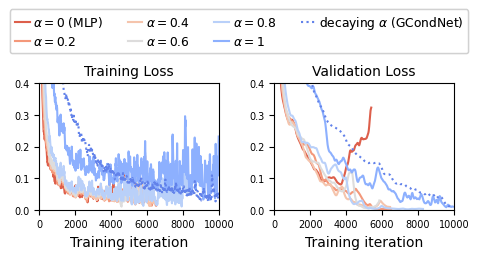

In [10]:
def plot_losses_interpolation_one_dataset(axis, time_series, dataset, metric, nr_interations, 
	ylim_bottom=None, ylim_top=None, show_ylabel=True,
	smoothing_filter1 = lambda series: series.ewm(span=50, adjust=True).mean(),
	smoothing_filter2 = lambda series: series.rolling(window=20, win_type='gaussian', min_periods=20, center=True).mean(std=10),
):
	colors = list(sns.color_palette("coolwarm", n_colors=7).as_hex())[::-1]
	for i, alpha in enumerate([0, 0.2, 0.4, 0.6, 0.8, 1, 'decay']):
		label = f'$\\alpha={alpha}$'
		if alpha == 0:
			label += ' (MLP)'
		elif alpha == 'decay':
			label = 'decaying $\\alpha$ (GCondNet)'

		# elif alpha == 1:
			# label += ' (end-to-end)'
		
		data = time_series[(dataset, metric, alpha)]
		data = smoothing_filter1(data.mean(axis=1))
		if smoothing_filter2:
			data = smoothing_filter2(data)

		if alpha == 'decay':
			axis.plot(data.index, data, label=label, color=colors[i], linestyle='dotted')
		else:
			axis.plot(data.index, data, label=label, color=colors[i])


	# PLOTTING SETTINGS
	axis.set_xlim(0, nr_interations)

	if ylim_bottom is not None:
		axis.set_ylim(bottom=ylim_bottom)
	if ylim_top is not None:
		axis.set_ylim(top=ylim_top)

	axis.tick_params(axis='both', which='major', labelsize=7)
	axis.locator_params(axis='both', nbins=5)

	dataset = dataset.replace('_', '-')
	# axis.set_title(f'{dataset}      {metric}')
	axis.set_title(f'{dataset}', fontsize=14)
	axis.set_xlabel('Training iteration')
	if show_ylabel:
		if metric == 'train/cross_entropy_loss':
			# axis.set_ylabel('Loss', fontsize=11)
			axis.set_title(f'Training Loss', fontsize=10)
		elif metric == 'valid/cross_entropy_loss':
			# axis.set_ylabel('Loss', fontsize=11)
			axis.set_title(f'Validation Loss', fontsize=10)
		else:
			axis.set_ylabel(metric, fontsize=11)
	# axis.legend()



nr_interations = 10000

fig, axis = make_subplots(functions=
	[
		[
	 		partial(plot_losses_interpolation_one_dataset, 
				time_series=time_series, dataset='toxicity', metric='train/cross_entropy_loss',
				nr_interations=nr_interations, ylim_bottom=0, ylim_top=0.4, show_ylabel=True),
            partial(plot_losses_interpolation_one_dataset, 
				time_series=time_series, dataset='toxicity', metric='valid/cross_entropy_loss',
				nr_interations=nr_interations, ylim_bottom=0, ylim_top=0.4, show_ylabel=True),
		]
	],
	figsize_col=2.5, figsize_row=2.3,
	# suptitle='Training/Validation losses for different interpolation values. \n Each column represents a dataset.',
);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = fig.legend(by_label.values(), by_label.keys(), ncol=4, loc='upper center', bbox_to_anchor=(0.51, 1.2), 
                    fontsize=8.8, handlelength=1.2, handletextpad=0.3, borderpad=0.4)

# add legend as artist
fig.artists.append(legend)

plt.tight_layout()